In [1]:
import os
import sys
if os.path.abspath('../src') not in sys.path:
    sys.path.append(os.path.abspath('../src'))
# os.environ["PYTHONPATH"] = '/opt/venv/lib/python3.11/site-packages'

import gc
import logging
import multiprocessing
import pickle
import time
from functools import partial
from pathlib import Path
from typing import Any, Literal

import dgl
import numpy as np
import pandas as pd
import pysmiles
import torch
from datasets import Dataset, IterableDataset, disable_caching, load_dataset
from dgl.dataloading import GraphDataLoader
from dgl.heterograph import DGLGraph
from easydict import EasyDict
from pymilvus import Collection, CollectionSchema, DataType, FieldSchema
from rdkit import Chem
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from data_processing import mol_to_dgl, networkx_to_dgl
from model import GNN

logging.getLogger('pysmiles').setLevel(logging.CRITICAL)


disable_caching()  # disables caching for datasets
from pymilvus import MilvusClient
client = MilvusClient("./milvus_demo.db")

/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MolRSmilesEmbedder:
    def __init__(
        self,
        model_path: str | Path,
        device: torch.device | None = None,
        ):
        self.model_path = Path(model_path)
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.load_model(self.model_path, self.device)

    def load_model(self, model_path: str | Path, device: torch.device):
        self.feature_encoder = pickle.load(model_path.joinpath('feature_enc.pkl').open('rb'))
        self.hparams = pickle.load(model_path.joinpath('hparams.pkl').open('rb'))
        self.embedder = GNN(self.hparams['gnn'], self.hparams['layer'], self.hparams['feature_len'], self.hparams['dim'])
        if torch.cuda.is_available():
            self.embedder.load_state_dict(
                torch.load(
                    model_path.joinpath('model.pt'), map_location=torch.device('cpu'), weights_only=True))
            self.embedder = self.embedder.to(device)
        else:
            self.embedder.load_state_dict(
                torch.load(
                    model_path.joinpath('model.pt'), map_location=torch.device('cpu'), weights_only=True))
        self.embedder.eval()


    def __call__(self, batch: dict[str, Any], rank: int=0):
        """Transforms SMILES into an embedding"""
        device = next(self.embedder.parameters()).device
        graphs = [self.smiles_to_dgl_rdkit(smiles, feature_encoder=self.feature_encoder) for smiles in batch['smiles']]
        graphs_gpu = [graph.to(device) for graph in graphs]
        with torch.no_grad():
             batch['vector'] = self.embedder(dgl.batch(graphs_gpu))
        return batch

    @staticmethod
    def smiles_to_dgl_rdkit(smiles: str, feature_encoder: dict[str, Any]) -> DGLGraph:
        mol = Chem.RemoveHs(Chem.MolFromSmiles(smiles))
        graph = mol_to_dgl(mol, feature_encoder)
        return graph


In [3]:
def create_schema_from_dataset(
    dataset: Dataset | IterableDataset, dimension: int, only_fields: list[str] | None = None) -> CollectionSchema:
    schema = MilvusClient.create_schema(
        auto_id=False,
        enable_dynamic_field=True,
    )

    # Add default fields
    schema.add_field(field_name="id", datatype=DataType.INT64, is_primary=True)
    schema.add_field(field_name="vector", datatype=DataType.FLOAT_VECTOR, dim=dimension)

    for field in dataset.features:
        if field in ('vector', 'id'):
            continue
        if only_fields and field not in only_fields:
            continue
        else:  # noqa: PLR5501
            if dataset.features[field].dtype == 'string' and field == 'smiles':
                # largest SMILES in Chembl is 1083 characters
                schema.add_field(field_name=field, datatype=DataType.VARCHAR, max_length=1200)
            # elif dataset.features[field].dtype == 'string':
            #     schema.add_field(field_name=field, datatype=DataType.VARCHAR)
            elif dataset.features[field].dtype == 'float32':
                schema.add_field(field_name=field, datatype=DataType.FLOAT)
            elif dataset.features[field].dtype == 'float64':
                schema.add_field(field_name=field, datatype=DataType.DOUBLE)
            elif dataset.features[field].dtype == 'int64':
                schema.add_field(field_name=field, datatype=DataType.INT64)
            elif dataset.features[field].dtype == 'bool':
                schema.add_field(field_name=field, datatype=DataType.BOOL)
            else:
                raise ValueError(
                    f"Unsupported datatype {dataset.features[field].dtype} for field {field}")
    return schema


def set_up_index_params(client, extra_scalar_fields_to_index: list[str] | None = None) -> dict[str, Any]:
    index_params = client.prepare_index_params()
    index_params.add_index(
        field_name="vector",
        index_type="FLAT",  # HNSW
        metric_type="L2",
    )
    index_params.add_index(
        field_name="id",
        index_type="INVERTED",
    )
    if extra_scalar_fields_to_index:
        for field in extra_scalar_fields_to_index:
            index_params.add_index(
                field_name=field,
                index_type="INVERTED",
            )
    return index_params

In [4]:
class MilvusInserter:
    def __init__(
        self,
        client: MilvusClient,
        collection_name: str = 'chembl',
        ):
        self.client = client
        self.collection_name = collection_name

    def __call__(self, data: dict[str, Any], indices: list[int] | None = None, rank: int | None = None):
        """Transforms SMILES into an embedding"""
        data['id'] = indices
        _ = self.client.insert(data=[dict(data)], collection_name=self.collection_name)
        return data

    def __call_bb__(self, batch: dict[str, Any], indices: list[int] | None = None, rank: int | None = None):
        """Transforms SMILES into an embedding"""
        batch['id'] = indices
        _ = self.client.insert(data=dict(batch), collection_name=self.collection_name)
        return batch


In [5]:
MODEL_PATH = Path('../saved/tag_1024')
DATA_PATH = Path("../../data/CS2/train.csv")

embedder = MolRSmilesEmbedder(MODEL_PATH)
dataset = load_dataset('csv', data_files=str(DATA_PATH), split='train').select(range(10000))
emb_dataset = dataset.map(embedder, batched=True, batch_size=1024)
dimension = len(emb_dataset[0]['vector'])
print(f"embedding dimension: {dimension}")

Map: 100%|██████████| 10000/10000 [00:30<00:00, 327.04 examples/s]

embedding dimension: 1024


In [6]:
if client.has_collection(collection_name="chembl"):
    client.drop_collection("chembl")

schema = create_schema_from_dataset(emb_dataset, dimension, only_fields=['smiles', 'filters_passed', 'main_reward'])
index_params = set_up_index_params(client, extra_scalar_fields_to_index=['filters_passed', 'main_reward'])

client.create_collection(
    collection_name="chembl",
    schema=schema,
    index_params=index_params)

In [7]:
# examples = emb_dataset.select(range(10))
inserted = emb_dataset.select(range(1024)).map(MilvusInserter(client, 'chembl'), batched=False, with_indices=True)

Map: 100%|██████████| 1024/1024 [01:32<00:00, 11.13 examples/s]


In [35]:
def test_search_speed(client, dataset, batch_sizes=[16, 32, 64, 128], num_retries=5):
    times = []
    accuracies_top1 = []
    accuracies_top5 = []
    for batch_size in tqdm(batch_sizes, leave=False, desc='batch_size', position=0):
        times_per_run = []
        accuracies_top1_per_run = []
        accuracies_top5_per_run = []
        for _ in range(num_retries):
            random_indices = np.random.randint(0, len(dataset) - 1, batch_size)
            data = [dd for dd in dataset.select(random_indices)['vector']]
            start = time.time()
            res = client.search(
                collection_name="chembl",
                data=data,
                output_fields=["smiles", "main_reward"],
                limit=5,
            )
            end = time.time()
            times_per_run.append(end - start)
            retrieved_indices_top1 = [per_query[0]['id'] for per_query in res]
            retrieved_indices_top5 = [dd['id'] for per_query in res for dd in per_query]
            accuracies_top1_per_run.append(len(set(retrieved_indices_top1).intersection(set(random_indices))) / batch_size)
            accuracies_top5_per_run.append(len(set(retrieved_indices_top5).intersection(set(random_indices))) / batch_size)
        times.append(np.mean(times_per_run))
        accuracies_top1.append(np.mean(accuracies_top1_per_run))
        accuracies_top5.append(np.mean(accuracies_top5_per_run))
    result = pd.DataFrame({'batch_size': batch_sizes, 'time': times, 'accuracy_top1': accuracies_top1, 'accuracy_top5': accuracies_top5})
    result['time_per_mol'] = result['time'] / result['batch_size']
    return result

In [36]:
results = test_search_speed(client, inserted, batch_sizes=[16, 32, 64, 128], num_retries=5)

<Axes: title={'center': 'Search time per molecule'}, xlabel='batch size', ylabel='time (s)'>

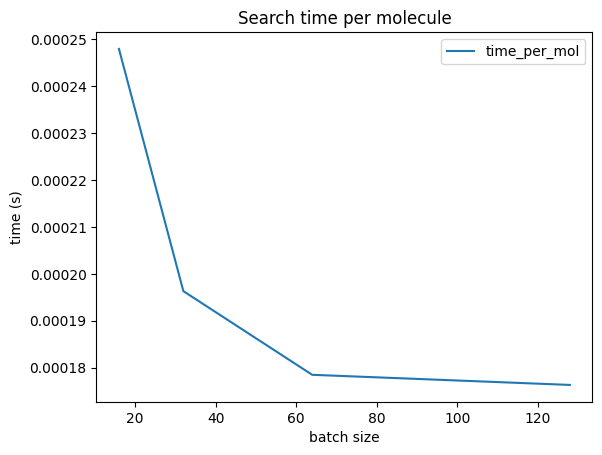

In [39]:
results.plot(x='batch_size', y='time_per_mol', title='Search time per molecule', ylabel='time (s)', xlabel='batch size')

<Axes: title={'center': 'Top 1 recall'}, xlabel='batch size', ylabel='recall'>

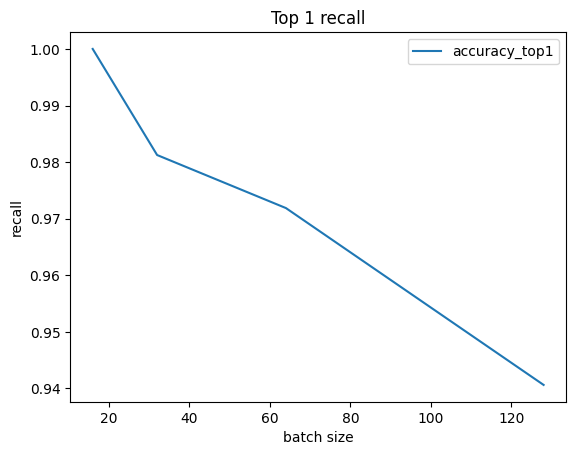

In [42]:
results.plot(x='batch_size', y='accuracy_top1', title='Top 1 recall', ylabel='recall', xlabel='batch size')